# IMPORT LIBRARIES

In [2]:
# Libraries for Keras
from keras.models import load_model

# Another
import os
import numpy as np 
import cv2
import pandas as pd
from skimage import feature as ft 
from sklearn.externals import joblib
from PIL import Image
import matplotlib.pyplot as plt

# FUNCTION

## localization

In [3]:
# Use OpenCV to find Contours. Base on Contours we define is there any traffic signs in the image.
def preprocess_img(imgBGR, erode_dilate=True):
    """Preprocess the image for contour detection.
    Args:
        imgBGR: source image.
        erode_dilate: erode and dilate or not.
    Return:
        img_bin: a binary image (blue and red).
    """
    rows, cols, _ = imgBGR.shape
    imgHSV = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2HSV)

    Bmin = np.array([100, 43, 46])
    Bmax = np.array([124, 255, 255])
    img_Bbin = cv2.inRange(imgHSV,Bmin, Bmax)
    
    Rmin1 = np.array([0, 43, 46])
    Rmax1 = np.array([10, 255, 255])
    img_Rbin1 = cv2.inRange(imgHSV,Rmin1, Rmax1)
    
    Rmin2 = np.array([156, 43, 46])
    Rmax2 = np.array([180, 255, 255])
    img_Rbin2 = cv2.inRange(imgHSV,Rmin2, Rmax2)
    img_Rbin = np.maximum(img_Rbin1, img_Rbin2)
    img_bin = np.maximum(img_Bbin, img_Rbin)

    if erode_dilate is True:
        kernelErosion = np.ones((9,9), np.uint8)
        kernelDilation = np.ones((9,9), np.uint8) 
        img_bin = cv2.erode(img_bin, kernelErosion, iterations=2)
        img_bin = cv2.dilate(img_bin, kernelDilation, iterations=2)

    return img_bin


def contour_detect(img_bin, min_area=0, max_area=-1, wh_ratio=2.0):
    """Detect contours in a binary image.
    Args:
        img_bin: a binary image.
        min_area: the minimum area of the contours detected.
            (default: 0)
        max_area: the maximum area of the contours detected.
            (default: -1, no maximum area limitation)
        wh_ratio: the ration between the large edge and short edge.
            (default: 2.0)
    Return:
        rects: a list of rects enclosing the contours. if no contour is detected, rects=[]
    """
    rects = []
    contours, _ = cv2.findContours(img_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) == 0:
        return rects

    max_area = img_bin.shape[0]*img_bin.shape[1] if max_area<0 else max_area
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_area and area <= max_area:
            x, y, w, h = cv2.boundingRect(contour)
            if 1.0*w/h < wh_ratio and 1.0*h/w < wh_ratio:
                rects.append([x,y,w,h])
    return rects

## Recognition

In [4]:
# Define
## Constant
### Image Size
height = 32
width = 32
### Accepted Accuracy for result of prediction
result_accuracy = 0.8

## Load Model
model = load_model('model.h5')
print("Load model success")

# Function
def sign_recognition(images):
    """ Use model train before predict image.
    Args:
        images: traffic signs after detection
    Return:
        pred: classes of the traffic signs
    """
    data=[]
    for image in images:
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((height, width))
        data.append(np.array(size_image))
    X_test=np.array(data)
    X_test = X_test.astype('float32')/255
    pred = [-1]
    if np.amax(model.predict(X_test)) >= result_accuracy:
        pred = model.predict_classes(X_test)
    return pred

Load model success


## Another

In [5]:
# Define
## Load lable
lable_data=pd.read_csv("./input/signnames.csv")
lable_value=lable_data['SignName'].values
print("Load lable success")

# Function
def load_name(index):
    """ Return name of the traffic sign's class
    Args:
        index: class id
    Return:
        Name of the traffic sign's class
    """
    if index == -1:
        return "Undentified"
    return lable_value[index]
def draw_rects_on_img(img, rects):
    """ draw rects on an image.
    Args:
        img: an image where the rects are drawn on.
        rects: a list of rects.
    Return:
        img_rects: an image with rects.
    """
    img_copy = img.copy()
    for rect in rects:
        x, y, w, h = rect
        cv2.rectangle(img_copy, (x,y), (x+w,y+h), (0,255,0), 2)
    return img_copy

Load lable success


# MAIN

## Load Predict Image

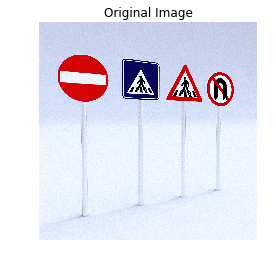

In [6]:
img = cv2.imread("./input/predict/01.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Original Image')
plt.show()

## Convert Image to Binary Image

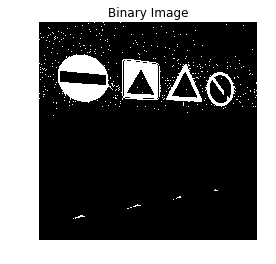

In [7]:
img_bbx = img.copy()
rows, cols, _ = img.shape
img_bin = preprocess_img(img,False)
# cv2.imshow("bin image", img_bin)
# cv2.imwrite("bin_image.jpg", img_bin)
plt.imshow(cv2.cvtColor(img_bin, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Binary Image')
plt.show()

## localize Traffic Sign(Find Contours and draw to Image)

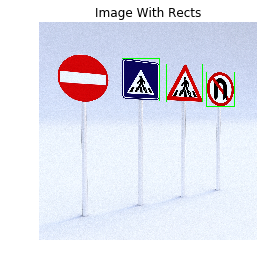

In [8]:
min_area = img_bin.shape[0]*img.shape[1]/(25*25)
rects = contour_detect(img_bin, min_area=min_area)
img_rects = draw_rects_on_img(img, rects)
# cv2.imshow("image with rects", img_rects)
# cv2.imwrite("image_rects.jpg", img_rects)
plt.imshow(cv2.cvtColor(img_rects, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Image With Rects')
plt.show()

## Recognize Traffic sign

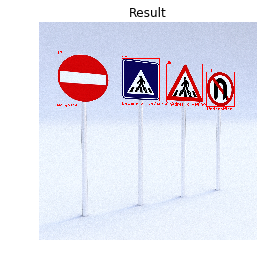

In [9]:
for rect in rects:
    xc = int(rect[0] + rect[2]/2)
    yc = int(rect[1] + rect[3]/2)
    size = max(rect[2], rect[3])
    x1 = max(0, int(xc-size/2))
    y1 = max(0, int(yc-size/2))
    x2 = min(cols, int(xc+size/2))
    y2 = min(rows, int(yc+size/2))
    proposal = img[y1:y2, x1:x2]
    result = sign_recognition([proposal])[0]
    cv2.rectangle(img_bbx,(rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (0,0,255), 2)
    cv2.putText(img_bbx, str(result), (rect[0], rect[1]), 1, 1.5, (0,0,255),2)
    cv2.putText(img_bbx, load_name(result), (rect[0], rect[1]+rect[3]+20), 1, 1.5, (0,0,255),2)        
# cv2.imshow("detect result", img_bbx)
# cv2.imwrite("detect_result.jpg", img_bbx)
# cv2.waitKey(0)
plt.imshow(cv2.cvtColor(img_bbx, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Result')
plt.show()